# Named Entity Recognition (NER) with BiLSTMs, CRFs, and Viterbi Decoding

L'un des éléments fondamentaux de NLP est la reconnaissance d'entité nommée (NER). Les noms de personnes, d'entreprises, de produits et de quantités peuvent être étiquetés dans un texte avec NER, ce qui est très utile dans les applications de chatbot et de nombreux autres cas d'utilisation dans la recherche et l'extraction d'informations. Le NER sera l'objet principal de ce guide. La construction et la formation d'un modèle capable de faire du NER nécessitent plusieurs techniques, telles que les champs aléatoires conditionnels (CRF) et les LSTM bidirectionnels (BiLSTM). Des techniques TensorFlow avancées telles que des couches personnalisées, des pertes et des boucles d'entraînement sont également utilisées. Plus précisément, les points suivants seront couverts.

* Présentation du NER
* Création d'un modèle de marquage NER avec BiLSTM
* CRF et algorithmes de Viterbi
* Création d'une couche Keras personnalisée pour les CRF
* Création d'une fonction de perte personnalisée dans Keras et TensorFlow
* Formation d'un modèle avec une boucle d'entraînement personnalisée

Tout commence par la compréhension du NER, qui est l'objet de la section suivante

## Reconnaissance d'entités nommées 

Étant donné une phrase ou un morceau de texte, l'objectif d'un modèle NER est de localiser et de classer les jetons de texte en tant qu'entités nommées dans des catégories telles que les noms de personnes, d'organisations et d'entreprises, les emplacements physiques, les quantités, les quantités monétaires, les heures, les dates , et même des séquences de protéines ou d'ADN.

Il existe différents ensembles de données et schémas de marquage qui peuvent être utilisés pour former des modèles NER. Différents ensembles de données auront différents sous-ensembles des balises répertoriées ci-dessus. Dans d'autres domaines, il peut y avoir des balises supplémentaires spécifiques au domaine. Le Defense Science Technology Laboratory au Royaume-Uni a créé un ensemble de données appelé re3d (https://github.com/dstl/re3d), qui contient des types d'entités tels que véhicule (Boeing 777), arme (rifle) et plate-forme militaire. (tank). La disponibilité d'ensembles de données étiquetés de taille adéquate dans diverses langues est un défi important. Voici un lien vers une bonne collection d'ensembles de données NER : https://github.com/juand-r/entity-recognition-datasets. Dans de nombreux cas d'utilisation, vous devrez passer beaucoup de temps à collecter et à annoter des données. Par exemple, si vous créez un chatbot pour commander des pizzas, les entités peuvent être des bases, des sauces, des tailles et des garnitures.

Voici quelques façons différentes de construire un modèle NER. Si la phrase est considérée comme une séquence, alors cette tâche peut être modélisée comme une tâche d'étiquetage mot à mot. Par conséquent, des modèles similaires aux modèles utilisés pour le balisage des parties de la parole (POS) sont applicables. Des fonctionnalités peuvent être ajoutées à un modèle pour améliorer l'étiquetage. Le POS d'un mot et ses mots voisins sont les fonctionnalités les plus simples à ajouter. Les fonctions de forme de mot qui modélisent les lettres minuscules peuvent ajouter beaucoup d'informations, principalement parce que de nombreux types d'entités traitent des noms propres, tels que ceux des personnes et des organisations. Les noms d'organisation peuvent être abrégés. Par exemple, l'Organisation mondiale de la santé peut être représentée en tant qu'OMS. Notez que cette fonctionnalité ne fonctionnera que dans les langues qui font la distinction entre les lettres minuscules et majuscules.

Une autre caractéristique essentielle consiste à vérifier un mot dans un répertoire géographique. Un index géographique est comme une base de données d'entités géographiques importantes. Voir geonames.org pour un exemple d'ensemble de données sous licence Creative Commons. Un ensemble de noms de personnes aux États-Unis peut être obtenu auprès de la US Social Security Administration à l'adresse https://www.ssa.gov/oact/babynames/state/namesbystate.zip. Le fichier ZIP lié contient les noms des personnes nées aux États-Unis depuis 1910, regroupés par État. De même, Dunn and Bradstreet, connu sous le nom de D&B, propose un ensemble de données d'entreprises avec plus de 200 millions d'entreprises à travers le monde qui peuvent être licenciées. Le plus grand défi avec cette approche est la complexité de maintenir ces listes au fil du temps.

Dans ce guide, nous nous concentrerons sur un modèle qui ne repose pas sur des données externes supplémentaires en plus des données étiquetées pour la formation, comme un index géographique, et qui ne dépend pas non plus des caractéristiques fabriquées à la main. Nous essaierons d'atteindre un niveau de précision aussi élevé que possible en utilisant des réseaux de neurones profonds et quelques techniques supplémentaires. Le modèle que nous utiliserons sera une combinaison de BiLSTM et d'un CRF par dessus. Ce modèle est basé sur l'article intitulé Neural Architectures for Named Entity Recognition, écrit par Guillaume Lample et al. et présenté à la conférence NAACL-HTL en 2016. Cet article était à la pointe de la technologie en 2016 avec un score F1 de 90,94. Actuellement, le SOTA a un score F1 de 93,5, où le modèle utilise des données d'entraînement supplémentaires. Ces chiffres sont mesurés sur l'ensemble de données anglais CoNLL 2003. L'ensemble de données GMB sera utilisé dans ce guide. La section suivante décrit cet ensemble de données

## L'ensemble de données GMB

Avec toutes les bases dans le sac, nous sommes prêts à construire un modèle qui classe les NER. Pour cette tâche, l'ensemble de données Groningen Meaning Bank (GMB) sera utilisé. Cet ensemble de données n'est pas considéré comme un étalon-or. Cela signifie que cet ensemble de données est construit à l'aide d'un logiciel de marquage automatique, suivi par des évaluateurs humains mettant à jour des sous-ensembles de données. Cependant, il s'agit d'un ensemble de données très volumineux et riche. Ces données contiennent de nombreuses annotations utiles qui les rendent tout à fait adaptées aux modèles d'entraînement. Il est également construit à partir de texte du domaine public, ce qui le rend facile à utiliser pour la formation. Les entités nommées suivantes sont étiquetées dans ce corpus

* geo = Geographical entity
* org = Organization
* per = Person
* gpe = Geopolitical entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural phenomenon

Dans chacune de ces catégories, il peut y avoir des sous-catégories. Par exemple, tim peut être encore subdivisé et représenté comme tim-dow représentant une entité temporelle correspondant à un jour de la semaine, ou tim-dat, qui représente une date. Pour cet exercice, ces sous-entités seront agrégées dans les huit entités de niveau supérieur énumérées ci-dessus. Le nombre d'exemples varie considérablement entre les sous-entités. Par conséquent, la précision varie considérablement en raison du manque de données d'entraînement suffisantes pour certaines de ces sous-catégories.


L'ensemble de données fournit également l'entité NER pour chaque mot. Dans de nombreux cas, une entité peut comprendre plusieurs mots. Si Hyde Park est une entité géographique, les deux mots seront marqués comme une entité géographique. En termes de modèles d'entraînement pour le NER, il existe une autre façon de représenter ces données qui peut avoir un impact significatif sur la précision du modèle. Cela nécessite l'utilisation du système de marquage BIO. Dans ce schéma, le premier mot d'une entité, un seul mot ou plusieurs mots, est marqué avec B-{entity tag}. Si l'entité est composée de plusieurs mots, chaque mot successif serait étiqueté comme I-{balise d'entité}. Dans l'exemple ci-dessus, Hyde Park serait étiqueté comme B-geo I-geo. Toutes ces étapes de pré-traitement sont nécessaires pour un ensemble de données

.Commençons par charger et traiter les données

## Chargement des données

Les données peuvent être téléchargées sur le site Web de l'Université de Groningue comme suit :

In [ ]:
#!wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip
#!unzip gmb-2.2.0.zip

Veuillez noter que les données sont assez volumineuses – plus de 800 MB. Si wget n'est pas disponible sur votre système, vous pouvez utiliser tout autre outil tel que curl ou un navigateur pour télécharger l'ensemble de données. Cette étape peut prendre un certain temps. Si vous rencontrez des difficultés pour accéder à l'ensemble de données à partir du serveur de l'Université, vous pouvez télécharger une copie depuis Kaggle : https://www.kaggle.com/bradbolliger/gmb-v220. Notez également que puisque nous allons travailler sur de grands ensembles de données, certaines des étapes suivantes peuvent prendre un certain temps à s'exécuter. Dans le monde du traitement du langage naturel (NLP), plus de données d'entraînement et de temps d'entraînement sont la clé d'excellents résultats

Les données se décompressent dans le dossier gmb-2.2.0. Le sous-dossier de données a un certain nombre de sous-dossiers avec des fichiers différents. Le fichier README fourni avec l'ensemble de données fournit des détails sur les différents fichiers et leur contenu. Pour cet exemple, nous utiliserons uniquement des fichiers nommés en.tags dans divers sous-répertoires. Ces fichiers sont des fichiers séparés par des tabulations avec chaque mot d'une phrase d'affilé

Il y a dix colonnes d'informations :

* Le jeton lui-même
* Une balise POS telle qu'elle est utilisée dans la Penn Treebank (ftp://ftp.cis.upenn.edu/pub/treebank/doc/tagguide.ps.gz)
* Un lemme
* Une balise d'entité nommée, ou 0 si aucune
* Un numéro de sens de mot WordNet pour les combinaisons lemme-POS respectives, ou 0 si non applicable (http://wordnet.princeton.edu)
* Pour les verbes et les prépositions, une liste des Rôles VerbNet des arguments par ordre de combinaison dans la dérivation de la grammaire catégorielle combinatoire (CCG), ou [] si non applicable (http://verbs.colorado.edu/~mpalmer/projects/verbnet.html)

* Relation sémantique dans le nom -nom composés, apostrophes possessives, modificateurs temporels, etc. Indiqué à l'aide d'une préposition, ou 0 si non applicable
* Un tag d'animation tel que proposé par Zaenen et al. (2004), ou 0 si non applicable (http://dl.acm.org/citation.cfm?id=1608954)
* Un supertag (catégorie lexicale de CCG)
* Le lambda-DRS représentant la sémantique du token dans Boxer's Format prologue


Parmi ces champs, nous allons utiliser uniquement le jeton et la balise d'entité nommée. Cependant, nous travaillerons en chargeant la balise POS pour un exercice futur. Le code suivant récupère tous les chemins de ces fichiers de balises

In [ ]:
import os
data_root = './gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [ ]:
fnames[:2]

['./gmb-2.2.0/data/p40/d0249/en.tags', './gmb-2.2.0/data/p40/d0064/en.tags']

Quelques étapes de traitement doivent avoir lieu. Chaque fichier a un certain nombre de phrases, avec chaque mot dans une rangée. La phrase entière sous forme de séquence et la séquence correspondante de balises NER doivent être introduites en tant qu'entrées lors de la formation du modèle. Comme mentionné ci-dessus, les balises NER doivent également être simplifiées aux entités de niveau supérieur uniquement. Deuxièmement, les balises NER doivent être converties au format IOB. IOB signifie In-Other-Begin. Ces lettres sont utilisées comme préfixe de la balise NER. Le fragment de phrase dans le tableau ci-dessous montre comment ce schéma fonctionne
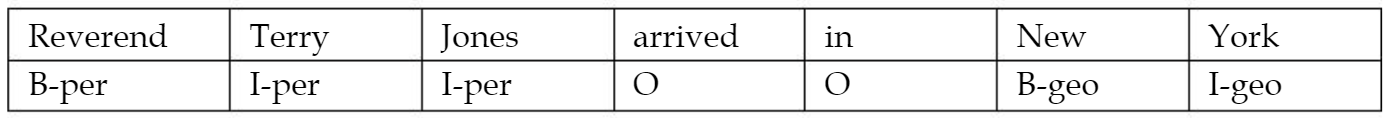

Le tableau ci-dessus montre ce schéma de marquage après traitement. Notez que New York est un endroit. Dès que New est rencontré, il marque le début de la balise geo NER, c'est pourquoi il lui est attribué B-geo. Le mot suivant est York, qui est une continuation de la même entité géographique. Pour tout réseau, classer le mot Nouveau comme début de l'entité géographique va être très difficile. Cependant, un réseau BiLSTM serait capable de voir les mots suivants, ce qui aide beaucoup à la désambiguïsation. De plus, l'avantage des balises IOB est que la précision du modèle s'améliore considérablement en termes de détection. Cela se produit car une fois le début d'une balise NER détecté, les choix pour la balise suivante deviennent assez limités

Venons-en au code. Tout d'abord, créez un répertoire pour stocker tous les fichiers traités :

In [ ]:
!mkdir ner 

Nous voulons traiter les balises de manière à supprimer les sous-catégories des balises NER. Il serait également intéressant de collecter des statistiques sur les types de balises dans les documents :

In [ ]:
import csv
import collections
 
ner_tags = collections.Counter()
iob_tags = collections.Counter()

def strip_ner_subcat(tag):
    # NER tags are of form {cat}-{subcat}
    # eg tim-dow. We only want first part
    return tag.split("-")[0]

Les compteurs de balises NER et IOB sont configurés ci-dessus. Une méthode pour supprimer la sous-catégorie des balises NER est définie. La méthode suivante prend une séquence de balises et les convertit au format IOB :

In [ ]:
def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        iob_tags[token] += 1
    return iob_tokens  

Une fois ces deux fonctions de commodité prêtes, tous les fichiers de balises doivent être lus et traités :

In [ ]:
total_sentences = 0
outfiles = []
for idx, file in enumerate(fnames):
    with open(file, 'rb') as content:
        data = content.read().decode('utf-8').strip()
        sentences = data.split("\n\n")
        total_sentences += len(sentences)
        
        with open("./ner/"+str(idx)+"-"+os.path.basename(file), 'w') as outfile:
            outfiles.append("./ner/"+str(idx)+"-"+os.path.basename(file))
            writer = csv.writer(outfile)
            
            for sentence in sentences: 
                toks = sentence.split('\n')
                words, pos, ner = [], [], []
                
                for tok in toks:
                    t = tok.split("\t")
                    words.append(t[0])
                    pos.append(t[1])
                    ner_tags[t[3]] += 1
                    ner.append(strip_ner_subcat(t[3]))
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)])

Tout d'abord, un compteur est défini pour le nombre de phrases. Une liste de fichiers écrits avec des chemins est également initialisée. Au fur et à mesure que les fichiers traités sont écrits, leurs chemins sont ajoutés à la variable outfiles. Cette liste sera utilisée plus tard pour charger toutes les données et pour entraîner le modèle. Les fichiers sont lus et divisés en deux caractères de nouvelle ligne vides. C'est le marqueur pour la fin d'une phrase dans le fichier. Seuls les mots réels, les jetons POS et les jetons NER sont utilisés à partir du fichier. Une fois ceux-ci collectés, un nouveau fichier CSV est écrit avec trois colonnes : la phrase, une séquence de balises POS et une séquence de balises NER. Cette étape peut prendre un peu de temps à s'exécuter :

In [ ]:
print("total number of sentences: ", total_sentences)

total number of sentences:  62010


Pour confirmer la distribution des balises NER avant et après traitement, on peut utiliser le code suivant :

In [ ]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'org-leg': 60, 'per-ini': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62})


Comme on le voit, certaines balises étaient très peu fréquentes, comme tim-dom. Il serait presque impossible pour un réseau de les apprendre. L'agrégation d'un niveau permet d'augmenter le signal de ces balises. Pour vérifier si l'ensemble du processus s'est terminé correctement, vérifiez que le dossier ner contient 10 000 fichiers. Maintenant, chargeons les données traitées pour les normaliser, les tokeniser et les vectoriser

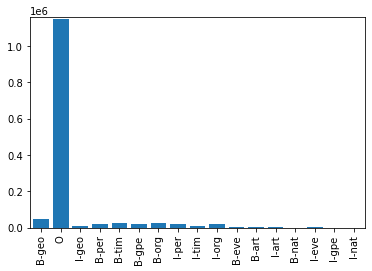

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels, values = zip(*iob_tags.items())

indexes = np.arange(len(labels))


plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

## Normaliser et vectoriser les données

Pour cette section, les méthodes pandas et numpy seront utilisées. La première étape consiste à charger le contenu des fichiers traités dans un DataFrame

In [ ]:
import glob
import pandas as pd

# could use `outfiles` param as well
files = glob.glob("./ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, 
                                 names=["text", "label", "pos"]) 
                for f in files], ignore_index = True)

Cette étape peut prendre un certain temps étant donné qu'elle traite 10 000 fichiers. Une fois le contenu chargé, on peut vérifier la structure du DataFrame

In [ ]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


Le texte et les balises NER doivent être tokenisés et codés en nombres pour être utilisés dans la formation. Nous allons utiliser les méthodes de base fournies par le package keras.preprocessing. Tout d'abord, le tokenizer sera utilisé pour tokeniser le texte. Dans cet exemple, le texte n'a besoin d'être marqué que par des espaces blancs, car il a déjà été divisé

In [ ]:
### Keras tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
text_tok = Tokenizer(filters='[\\]^\t\n', lower=False,
                     split=' ', oov_token='<OOV>')

pos_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

ner_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

Les valeurs par défaut pour le tokenizer sont tout à fait raisonnables. Cependant, dans ce cas particulier, il est important de ne tokeniser que les espaces et de ne pas nettoyer les caractères spéciaux. Sinon, les données seront mal formatées

In [ ]:
text_tok.fit_on_texts(data_pd['text'])
pos_tok.fit_on_texts(data_pd['pos'])
ner_tok.fit_on_texts(data_pd['label'])

    Même si nous n'utilisons pas les balises POS, le traitement de celles-ci
    est inclus. L'utilisation des balises POS peut avoir un impact sur la
    précision d'un modèle NER. De nombreuses entités NER sont des noms, par
    exemple. Cependant, nous verrons comment traiter les balises POS sans les
    utiliser dans le modèle en tant que fonctionnalités. Ceci est laissé en
    exercice au lecteur

Ce tokenizer a quelques fonctionnalités utiles. Il fournit un moyen de restreindre la taille du vocabulaire par le nombre de mots, TF-IDF, etc. Si le paramètre num_words est passé avec une valeur numérique, le tokenizer limitera le nombre de jetons par fréquences de mots à ce nombre. La méthode fit_on_texts prend tous les textes, les tokenise et construit des dictionnaires avec des tokens qui seront utilisés plus tard pour tokeniser et encoder en une seule fois. Une fonction de commodité, get_config(), peut être appelée après que le tokenizer a été placé sur des textes pour fournir des informations sur les tokens

In [ ]:
ner_config = ner_tok.get_config()
text_config = text_tok.get_config()

In [ ]:
print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"B-gpe": 20436, "O": 1146068, "B-per": 21984, "I-per": 22270, "B-tim": 26296, "I-tim": 8493, "B-geo": 48876, "I-geo": 9512, "B-org": 26195, "I-org": 21899, "B-art": 503, "I-art": 364, "I-gpe": 244, "B-eve": 391, "I-eve": 318, "B-nat": 238, "I-nat": 62}', 'word_docs': '{"B-gpe": 16565, "O": 61999, "B-per": 17499, "I-per": 13805, "B-tim": 22345, "I-tim": 5526, "I-geo": 7738, "B-geo": 31660, "B-org": 20478, "I-org": 11011, "B-art": 425, "I-art": 207, "I-gpe": 224, "I-eve": 201, "B-eve": 361, "B-nat": 211, "I-nat": 50}', 'index_docs': '{"9": 16565, "2": 61999, "7": 17499, "6": 13805, "4": 22345, "11": 5526, "10": 7738, "3": 31660, "5": 20478, "8": 11011, "12": 425, "14": 207, "16": 224, "15": 201, "13": 361, "17": 211, "18": 50}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

La propriété de dictionnaire index_word dans la configuration fournit un mappage entre les ID et les jetons. Il y a une quantité considérable d'informations dans la config. Les vocabulaires peuvent être obtenus à partir de la config

In [ ]:
text_vocab = eval(text_config['index_word'])
ner_vocab = eval(ner_config['index_word'])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 39422
Unique NER tags in vocab: 18


La tokenisation et l'encodage du texte et des étiquettes d'entités nommées sont assez faciles

In [ ]:
x_tok = text_tok.texts_to_sequences(data_pd['text'])
y_tok = ner_tok.texts_to_sequences(data_pd['label'])

In [ ]:
print(text_tok.sequences_to_texts([x_tok[1]]), data_pd['text'][1])
print(ner_tok.sequences_to_texts([y_tok[1]]), data_pd['label'][1])

['The move to disband came after the new parliament confirmed opposition leader Kurmanbek Bakiyev as prime minister and appointed him acting president .'] The move to disband came after the new parliament confirmed opposition leader Kurmanbek Bakiyev as prime minister and appointed him acting president .
['O O O O O O O O O O O O B-per I-per O O O O O O O O O'] O O O O O O O O O O O O B-per I-per O O O O O O O O O


Étant donné que les séquences sont de tailles différentes, elles seront toutes rembourrées ou tronquées à une taille de 50 jetons. Une fonction d'assistance est utilisée pour cette tâche

In [ ]:
# now, pad seqences to a maximum length
from tensorflow.keras.preprocessing import sequence

max_len = 50

x_pad = sequence.pad_sequences(x_tok, padding='post',
                              maxlen=max_len)
y_pad = sequence.pad_sequences(y_tok, padding='post',
                              maxlen=max_len)

In [ ]:
print(x_pad.shape, y_pad.shape)

(62010, 50) (62010, 50)


In [ ]:
text_tok.sequences_to_texts([x_pad[1]])

['The move to disband came after the new parliament confirmed opposition leader Kurmanbek Bakiyev as prime minister and appointed him acting president . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [ ]:
ner_tok.sequences_to_texts([y_pad[1]])

['O O O O O O O O O O O O B-per I-per O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

La dernière étape ci-dessus consiste à s'assurer que les formes sont correctes avant de passer à l'étape suivante. La vérification des formes est une partie très importante du développement de code dans TensorFlow. Une étape supplémentaire doit être effectuée sur les étiquettes. Comme il existe plusieurs étiquettes, chaque jeton d'étiquette doit être encodé à chaud comme ceci

In [ ]:
import tensorflow as tf

num_classes = len(ner_vocab)+1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(62010, 50, 19)

## Un modèle BiLSTM

Le premier modèle que nous allons essayer est un modèle BiLSTM. Tout d'abord, les constantes de base doivent être configurées

In [ ]:
# Length of the vocabulary 
vocab_size = len(text_vocab) + 1 

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

Ensuite, une fonction de commodité pour l'instanciation des modèles est définie :

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense

dropout=0.2
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(units=rnn_units,
                           return_sequences=True,
                           dropout=dropout,  
                           kernel_initializer=tf.keras.initializers.he_normal())),
    TimeDistributed(Dense(rnn_units, activation='relu')),
    Dense(num_classes, activation="softmax")
  ])

  
  return model

Nous allons former nos propres embeddings. Après la couche d'intégration, il y a une couche BiLSTM, suivie d'une couche dense TimeDistributed. Cette dernière couche est différente du modèle d'analyse des sentiments, où il n'y avait qu'une seule unité pour la sortie binaire. Dans ce problème, pour chaque mot de la séquence d'entrée, un jeton NER doit être prédit. Ainsi, la sortie a autant de jetons que la séquence d'entrée. Par conséquent, les jetons de sortie correspondent 1 à 1 avec les jetons d'entrée et sont classés dans l'une des classes NER. La couche TimeDistributed fournit cette capacité. L'autre chose à noter dans ce modèle est l'utilisation de la régularisation. Il est important que le modèle ne surcharge pas les données d'apprentissage. Étant donné que les LSTM ont une capacité de modèle élevée, l'utilisation de la régularisation est très importante. N'hésitez pas à jouer avec certains de ces hyperparamètres pour avoir une idée de la réaction du modèle. Maintenant, le modèle peut être compilé

In [ ]:
model = build_model_bilstm(
                        vocab_size = vocab_size,
                        embedding_dim=embedding_dim,
                        rnn_units=rnn_units,
                        batch_size=BATCH_SIZE,
                        classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (90, None, 64)            2523072   
                                                                 
 bidirectional (Bidirectiona  (90, None, 200)          132000    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (90, None, 100)          20100     
 ibuted)                                                         
                                                                 
 dense_1 (Dense)             (90, None, 19)            1919      
                                                                 
Total params: 2,677,091
Trainable params: 2,677,091
Non-trainable params: 0
_________________________________________________________________


Ce modèle simpliste a plus de 2,6 millions de paramètres !


    Si vous remarquez, la majeure partie des paramètres proviennent de la
    taille du vocabulaire. Le vocabulaire compte 39 422 mots. Cela augmente le
    temps de formation du modèle et la capacité de calcul requise. Une façon de
    réduire cela est de réduire la taille du vocabulaire. La façon la plus
    simple de le faire serait de ne considérer que les mots qui ont plus d'une
    certaine fréquence d'occurrence ou de supprimer les mots plus petits qu'un
    certain nombre de caractères. Le vocabulaire peut également être réduit en
    convertissant tous les caractères en minuscules. Cependant, dans NER, la
    casse est une caractéristique très importante.

Ce modèle est prêt pour l'entraînement. La dernière chose qui est nécessaire est de diviser les données en ensembles d'apprentissage et de test :

In [ ]:
X = x_pad 
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = X[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = X[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49590, 50) (49590, 50, 19)
(12420, 50) (12420, 50, 19)



Maintenant, le modèle est prêt pour l'entraînement

In [ ]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)

Epoch 1/15
551/551 [==============================] - 138s 237ms/step - loss: 0.1860 - accuracy: 0.9034
Epoch 2/15
551/551 [==============================] - 129s 235ms/step - loss: 0.0483 - accuracy: 0.9676
Epoch 3/15
551/551 [==============================] - 129s 235ms/step - loss: 0.0350 - accuracy: 0.9755
Epoch 4/15
551/551 [==============================] - 130s 237ms/step - loss: 0.0292 - accuracy: 0.9787
Epoch 5/15
551/551 [==============================] - 130s 235ms/step - loss: 0.0253 - accuracy: 0.9811
Epoch 6/15
551/551 [==============================] - 130s 236ms/step - loss: 0.0220 - accuracy: 0.9835
Epoch 7/15
551/551 [==============================] - 132s 239ms/step - loss: 0.0194 - accuracy: 0.9854
Epoch 8/15
551/551 [==============================] - 131s 237ms/step - loss: 0.0169 - accuracy: 0.9871
Epoch 9/15
551/551 [==============================] - 130s 237ms/step - loss: 0.0149 - accuracy: 0.9887
Epoch 10/15
551/551 [==============================] - 132s 239m

Plus de 15 époques d'entraînement, le modèle se porte plutôt bien avec une précision de plus de 99%. Voyons comment le modèle fonctionne sur l'ensemble de test et si la régularisation a aidé :

In [ ]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 12s 71ms/step - loss: 0.0892 - accuracy: 0.9608


[0.08922986686229706, 0.9607612490653992]

Le modèle fonctionne bien sur l'ensemble de données de test, avec une précision de plus de 96,5 %. La différence entre les précisions du train et des tests est toujours là, ce qui implique que le modèle pourrait utiliser une régularisation supplémentaire. Vous pouvez jouer avec la variable dropout ou ajouter des couches dropout supplémentaires entre les couches d'intégration et BiLSTM, et entre la couche TimeDistributed et la couche final Dense

Voici un exemple de fragment de phrase tagué par ce modèle

In [ ]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
text_tok.sequences_to_texts([X_test[1]])

['The move to disband came after the new parliament confirmed opposition leader Kurmanbek Bakiyev as prime minister and appointed him acting president . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [ ]:
ner_tok.sequences_to_texts([y_pad[1]])

['O O O O O O O O O O O O B-per I-per O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [ ]:
y_pred = tf.argmax(y_pred, -1)
y_pred.shape

TensorShape([12420, 50])

In [ ]:
y_pnp = y_pred.numpy()

In [ ]:
ner_tok.sequences_to_texts([y_pnp[1]])

['O O O O O O O O O O O O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O']

Ce modèle ne marche pas mal du tout. Il a été capable d'identifier la personne et les entités temporelles dans la phrase. 

Aussi bon que soit ce modèle, il n'utilise pas une caractéristique importante des balises d'entité nommées : une balise donnée est fortement corrélée avec la balise qui la suit. Les CRF peuvent tirer parti de ces informations et améliorer encore la précision des tâches NER. Comprenons le fonctionnement des CRF et ajoutons-les au réseau ci-dessus suivant

## Conditional random elds (CRFs) 
Les modèles BiLSTM examinent une séquence de mots d'entrée et prédisent l'étiquette du mot actuel. Lors de cette détermination, seules les informations des entrées précédentes sont prises en compte. Les prédictions précédentes ne jouent aucun rôle dans la prise de cette décision. Cependant, il y a des informations codées dans la séquence d'étiquettes qui sont actualisées. Pour illustrer ce point, considérons un sous-ensemble de balises NER : O, B-Per, I-Per, B-Geo et I-Geo. Cela représente deux domaines de personnes et d'entités géographiques et une catégorie Autre pour tout le reste. Sur la base de la structure des balises IOB, nous savons que toute balise I doit être précédée d'un B-I du même domaine. Cela implique également qu'une balise I ne peut pas être précédée d'une balise O. Le schéma suivant montre les transitions d'état possibles entre ces balises

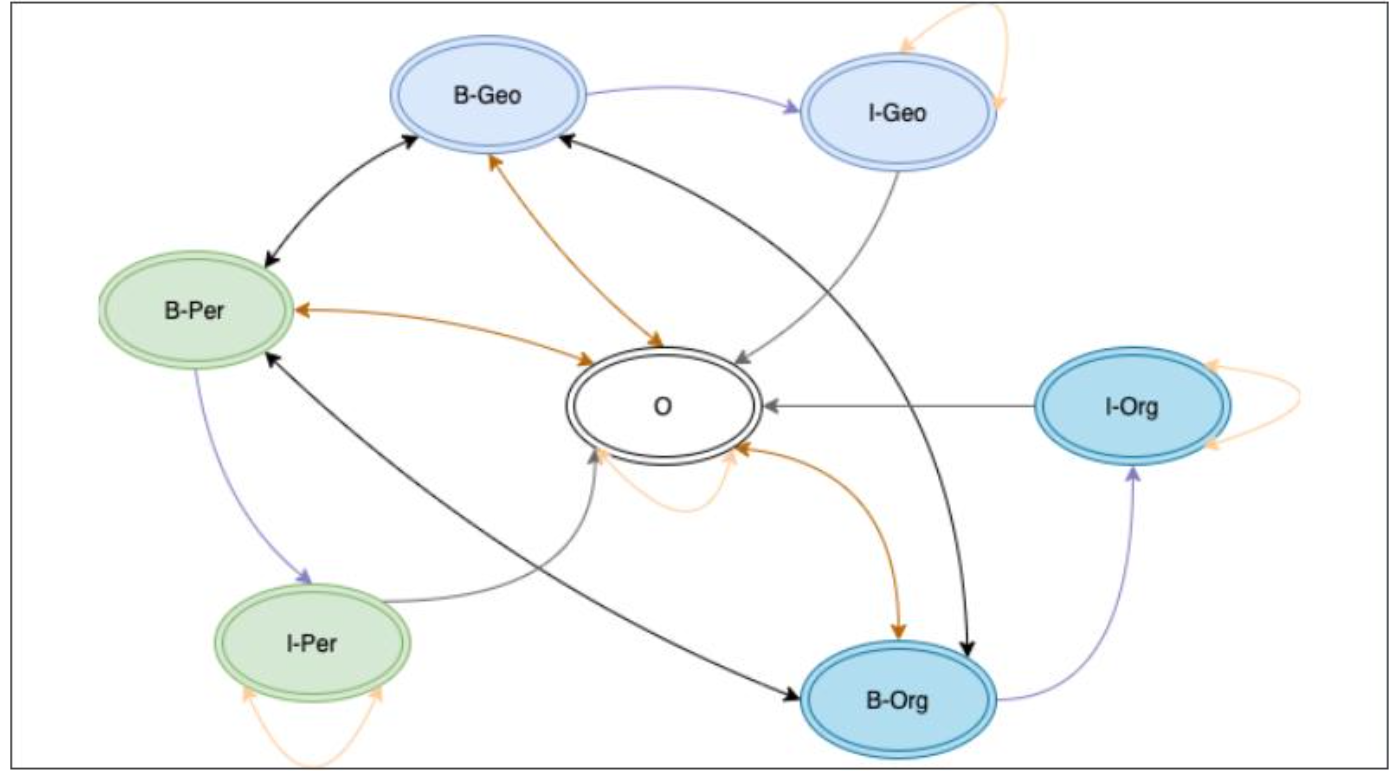

La figure code des types de transitions similaires avec la même couleur. Une balise O ne peut passer qu'à une balise B. Une balise B peut aller à sa balise I correspondante ou revenir à la balise O. Une balise I peut revenir à elle-même, une balise O ou une balise B d'un domaine différent (non représenté dans le diagramme pour plus de simplicité). Pour un ensemble de N balises, ces transitions peuvent être représentées par une matrice de dimension N x N. Pi,j désigne la possibilité que la balise j vienne après la balise i. Notez que ces poids de transition peuvent être appris en fonction des données. Une telle matrice de poids de transition apprise pourrait être utilisée pendant la prédiction pour considérer l'intégralité de la séquence d'étiquettes prédites et mettre à jour les probabilités.

Voici une matrice illustrative avec des poids de transition indicatifs

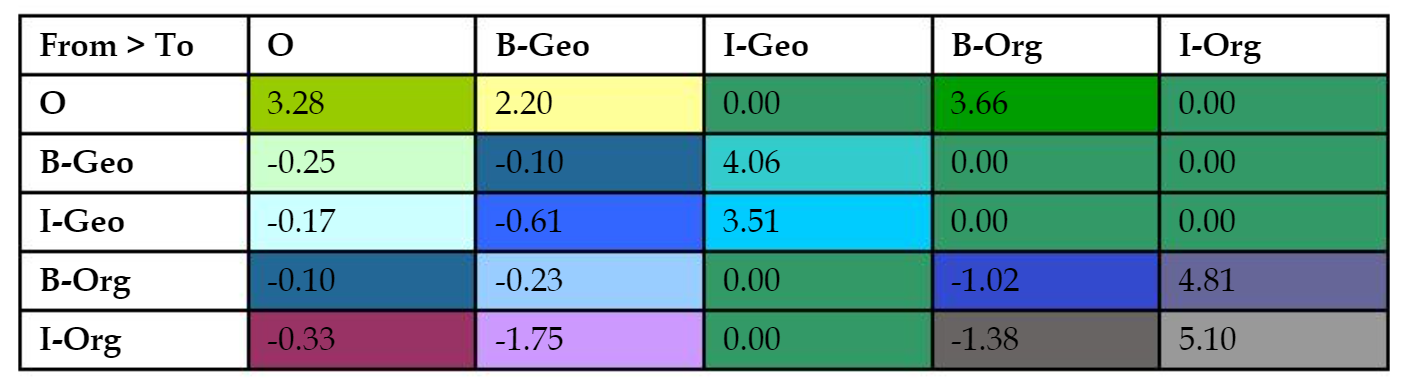

Selon le tableau ci-dessus, le poids du bord reliant I-Org à B-Org a un poids de -1,38, ce qui implique que cette transition est extrêmement improbable. Concrètement, la mise en œuvre d'un CRF comporte trois étapes principales. La première étape consiste à modifier le score généré par la couche BiLSTM et à prendre en compte les poids de transition, comme indiqué ci-dessus. Une séquence de prédictions

$$y=(y_1,y_2,...,y_n)$$

généré par la couche BiLSTM ci-dessus pour une séquence de n tags dans l'espace de k tags uniques est disponible, qui opère sur une séquence d'entrée X. P représente une matrice de dimensions n × k, où l'élément Pi,j représente la probabilité de jème balise pour la sortie à la position yi. Soit A une matrice carrée de probabilités de transition comme indiqué ci-dessus, avec une dimension de (k + 2) × (k + 2) où deux jetons supplémentaires sont ajoutés pour les marqueurs de début et de fin de phrase. L'élément Ai,j représente la probabilité de transition de i à l'étiquette j. En utilisant ces valeurs, un nouveau score peut être calculé comme ceci


$$S(X,y)=\sum_{i=0}^nA_{y_i,y_{i+1}}+\sum_{i=1}^nP_{i,y_i}$$

Un softmax peut être calculé sur toutes les séquences de balises possibles pour obtenir la probabilité pour une séquence donnée y

$$p(y|X)=\frac{e^{S(X,y)}}{\sum ỹ \in Y_Xe^{S(X,ỹ)}}$$

$Y_X$ représente toutes les séquences de balises possibles, y compris celles qui peuvent ne pas être conformes au format de balise IOB. Pour s'entraîner à l'aide de ce softmax, une log-vraisemblance peut être calculée dessus. Grâce à une utilisation intelligente de la programmation dynamique, une explosion combinatoire peut être évitée et le dénominateur peut être calculé de manière assez efcace.

Lors du décodage, la séquence de sortie est celle qui a le score maximum parmi ces séquences possibles, calculée conceptuellement à l'aide d'une fonction de style argmax. L'algorithme de Viterbi est couramment utilisé pour mettre en œuvre une solution de programmation dynamique pour le décodage. Tout d'abord, codons le modèle et l'entraînement pour celui-ci avant de commencer le décodage

## NER with BiLSTM and CRFs
La mise en œuvre d'un réseau BiLSTM avec des CRF nécessite l'ajout d'une couche CRF au-dessus du réseau BiLSTM développé ci-dessus. Cependant, un CRF ne fait pas partie intégrante des couches TensorFlow ou Keras. Il est disponible via le package tensorflow_addons ou tfa. La première étape consiste à installer ce paquet

In [ ]:
!pip install tensorflow_addons==0.11.2

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


Bien que des méthodes de bas niveau pour la mise en œuvre de la couche CRF soient fournies, une construction semblable à une couche de haut niveau n'est pas fournie. La mise en œuvre d'un CRF nécessite une couche personnalisée, une fonction de perte et une boucle d'apprentissage. Après la formation, nous verrons comment implémenter une fonction d'inférence personnalisée qui utilisera le décodage Viterbi

## Implémentation de la couche CRF personnalisée, de la perte et du modèle

Semblable au flux ci-dessus, il y aura une couche d'intégration et une couche BiLSTM. La sortie du BiLSTM doit être évaluée avec la perte de vraisemblance CRF décrite ci-dessus. C'est la perte qui doit être utilisée pour entraîner le modèle. La première étape de la mise en œuvre consiste à créer une couche personnalisée. L'implémentation d'une couche personnalisée dans Keras nécessite de sous-classer keras.layers.Layer. La méthode principale à implémenter est call(), qui prend les entrées dans la couche, les transforme et renvoie le résultat. De plus, le constructeur de la couche peut également configurer tous les paramètres nécessaires. Commençons par le constructeur

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class CRFLayer(Layer):
  """
  Computes the log likelihood during training
  Performs Viterbi decoding during prediction
  """
  def __init__(self,
               label_size,
               mask_id=0,
               trans_params=None,
               name='crf',
               **kwargs):
    super(CRFLayer, self).__init__(name=name, **kwargs)
    self.label_size = label_size
    self.mask_id = mask_id
    self.transition_params = None
    
    if trans_params is None:  # not reloading pretrained params
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)),
                                         trainable=False)
    else:
        self.transition_params = trans_params


  def call(self, inputs, seq_lengths, training=None):
    if training is None:
        training = K.learning_phase()
    
    # during training, this layer just returns the logits
    if training:
        return inputs
    
    # viterbi decode logic to return proper 
    # results at inference
    _, max_seq_len, _ = inputs.shape
    seqlens = seq_lengths
    paths = []
    for logit, text_len in zip(inputs, seqlens):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], 
                                              self.transition_params)
        paths.append(self.pad_viterbi(viterbi_path, max_seq_len))

    return tf.convert_to_tensor(paths) 
  
  def pad_viterbi(self, viterbi, max_seq_len):
    if len(viterbi) < max_seq_len:
        viterbi = viterbi + [self.mask_id] * (max_seq_len - len(viterbi))
    return viterbi


Les principaux paramètres nécessaires sont : 

* Le nombre d'étiquettes et la matrice de transition : Comme décrit dans la section ci-dessus, une matrice de transition doit être apprise. La dimension de cette matrice carrée est le nombre d'étiquettes. La matrice de transition est initialisée à l'aide des paramètres. Cette matrice de paramètres de transition ne peut pas être entraînée par descente de gradient. Il est calculé en conséquence du calcul des log-vraisemblances. La matrice des paramètres de transition peut également être transmise à cette couche si elle a été apprise dans le passé.

* L'identifiant du masque : Étant donné que les séquences sont rembourrées, il est important de récupérer les longueurs de séquence d'origine pour calculer les scores de transition. Par convention, une valeur de 0 est utilisée pour le masque, et c'est la valeur par défaut. Ce paramètre est configuré pour une configuration future


La deuxième méthode consiste à calculer le résultat de l'application de cette couche. Notez qu'en tant que couche, la couche CRF régurgite simplement les sorties pendant le temps d'entraînement. La couche CRF n'est utile que pendant l'inférence. Au moment de l'inférence, il utilise la matrice de transition et la logique pour corriger la sortie des séquences par les couches BiLSTM avant de les retourner. Pour l'instant, cette méthode est assez simple



Cette méthode prend les entrées ainsi qu'un paramètre qui permet de spécifier si cette méthode est appelée pendant l'apprentissage ou pendant l'inférence. Si cette variable n'est pas transmise, elle est extraite du backend Keras. Lorsque les modèles sont entraînés avec la méthode fit(), learning_phase() renvoie True. Lorsque la méthode .predict() est appelée sur un modèle, cet indicateur est défini sur false

Comme les séquences transmises sont masquées, cette couche doit connaître les longueurs réelles des séquences pendant le temps d'inférence pour le décodage. Une variable lui est transmise mais n'est pas utilisée pour le moment. Maintenant que la couche CRF de base est prête, construisons le modèle

## A custom CRF model

La première étape consiste à définir un constructeur qui créera les différentes couches et stockera les dimensions appropriées

Ce constructeur prend plus tard le nombre d'unités cachées pour le BiLSTM, la taille des mots dans le vocabulaire, le nombre d'étiquettes NER et la taille des plongements. De plus, un nom par défaut est défini par le constructeur, qui peut être remplacé au moment de l'instanciation. Tous les paramètres supplémentaires fournis sont transmis en tant qu'arguments de mot-clé

In [ ]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras import backend as K

class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size,
                name='BilstmCrfModel', **kwargs):
        super(NerModel, self).__init__(name=name, **kwargs)
        self.num_hidden = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size

        self.embedding = Embedding(vocab_size, embedding_size, 
                                   mask_zero=True, name="embedding")
        self.biLSTM =Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
        self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
        self.crf = CRFLayer(self.label_size, name="crf")

    def call(self, text, labels=None, training=None):
        seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), 
                                               dtype=tf.int32), axis=-1) 
        
        if training is None:
            training = K.learning_phase()

        inputs = self.embedding(text)
        bilstm = self.biLSTM(inputs)
        logits = self.dense(bilstm)
        outputs = self.crf(logits, seq_lengths, training)
        
        return outputs

Ainsi, en quelques lignes de code, nous avons implémenté un modèle client utilisant la couche CRF personnalisée développée ci-dessus. La seule chose dont nous avons besoin maintenant pour entraîner ce modèle est une fonction de perte



Implémentons la fonction de perte dans le cadre de la couche CRF, encapsulée dans une fonction du même nom. Notez que lorsque cette fonction est appelée, les étiquettes et les valeurs prédites lui sont généralement transmises. Nous allons modéliser notre fonction de perte sur les fonctions de perte personnalisées dans TensorFlow. Ajouter ce code à la classe de couche CRF

In [ ]:
def loss(self, y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

  seq_lengths = self.get_seq_lengths(y_true)
  log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, 
                                                              y_true, seq_lengths)

  # save transition params
  self.transition_params = tf.Variable(self.transition_params, trainable=False)
  # calc loss
  loss = - tf.reduce_mean(log_likelihoods)
  return loss


CRFLayer.loss = loss

Cette fonction prend les vraies étiquettes et les étiquettes prédites. Ces deux tenseurs sont généralement de la forme (taille du lot, longueur maximale de la séquence, nombre d'étiquettes NER). Cependant, la fonction de log-vraisemblance dans le package tfa s'attend à ce que les étiquettes soient dans un tenseur en forme de (taille du lot, longueur maximale de la séquence). Ainsi, une fonction de commodité, implémentée dans le cadre de la couche CRF et illustrée ci-dessous, est utilisée pour effectuer la conversion des formes d'étiquettes

In [ ]:
def get_proper_labels(self, y_true):
  shape = y_true.shape
  if len(shape) > 2:
      return tf.argmax(y_true, -1, output_type=tf.int32)
  return y_true

CRFLayer.get_proper_labels = get_proper_labels

La fonction de log-vraisemblance requiert également les longueurs de séquence réelles pour chaque exemple. Ces longueurs de séquence peuvent être calculées à partir des étiquettes et de l'identificateur de masque qui a été mis en place dans le constructeur de cette couche (voir ci-dessus). Ce processus est encapsulé dans une autre fonction de commodité, faisant également partie de la couche CRF

In [ ]:
def get_seq_lengths(self, matrix):
  # matrix is of shape (batch_size, max_seq_len)
  mask = tf.not_equal(matrix, self.mask_id)
  seq_lengths = tf.math.reduce_sum(
                                  tf.cast(mask, dtype=tf.int32), 
                                  axis=-1)
  return seq_lengths

CRFLayer.get_seq_lengths = get_seq_lengths

Tout d'abord, un masque booléen est généré à partir des étiquettes en comparant la valeur de l'étiquette à l'ID du masque. Ensuite, en transcrivant le booléen sous forme d'entier et en faisant la somme sur la ligne, la longueur de la séquence est régénérée. Maintenant, la fonction tfa.text.crf_log_likelihood() est appelée pour calculer et retourner les log-vraisemblances et la matrice de transition. La matrice de transition de la couche CRF est mise à jour avec la matrice de transition renvoyée par l'appel de fonction. Enfin, la perte est calculée en additionnant toutes les log-vraisemblances renvoyées. À ce stade, notre modèle personnalisé codé est prêt à commencer l'entraînement. Nous devrons configurer les données et créer une boucle d'entraînement personnalisée

## Implementing custom training

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = x_pad[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = x_pad[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]
Y_train_int = tf.cast(Y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

Environ 20 % des données sont réservées aux tests. Le reste est utilisé pour l'entraînement. Pour implémenter une boucle d'entraînement personnalisée, TensorFlow 2.0 expose une bande de dégradé. Cela permet une gestion de bas niveau des principales étapes nécessaires à l'entraînement de tout modèle avec descente de gradient. Ces étapes sont : 
* 1. Calcul des prédictions de passe avant
* 2. Calcul de la perte lorsque ces prédictions sont comparées aux 
* 3. Calcul des gradients pour les paramètres pouvant être entraînés en fonction de la perte, puis utilisation de l'optimiseur pour ajuster les 


Entraînons ce modèle pendant 5 époques et regardons la perte au fur et à mesure que l'entraînement progresse. Comparez cela aux 15 périodes d'entraînement pour le modèle précédent. La boucle d'entraînement personnalisée est illustrée ci-dessous :

In [ ]:
import tensorflow_addons as tfa
loss_metric = tf.keras.metrics.Mean()

epochs = 5

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (text_batch, labels_batch) in enumerate(train_dataset):
        labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
        with tf.GradientTape() as tape:
            logits = blc_model(text_batch, training=True)
            loss = blc_model.crf.loss(labels_max, logits)

            grads = tape.gradient(loss, blc_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))
            
            loss_metric(loss)
        if step % 50 == 0:
          print('step %s: mean loss = %s' % (step, loss_metric.result()))

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Start of epoch 0
step 0: mean loss = tf.Tensor(59.521404, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(30.79929, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(23.840704, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.625933, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(18.163263, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(16.445456, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(15.098897, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(14.032217, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(13.14641, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(12.418104, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(11.736778, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(11.106693, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(11.094193, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(10.537698, shape=(), dtype=float32)
step 100: mean loss = 

Une métrique est créée pour suivre la perte moyenne au fil du temps. Pour 5 époques, les entrées et les étiquettes sont extraites de l'ensemble de données d'apprentissage, un lot à la fois. En utilisant tf.GradientTape() pour suivre les opérations, les étapes décrites dans les puces ci-dessus sont implémentées. Notez que nous passons la variable entraînable manuellement car il s'agit d'une boucle d'entraînement personnalisée. Enfin, la métrique de perte est imprimée toutes les 50 étapes pour montrer les progrès de l'entraînement. Cela donne les résultats ci-dessous, qui ont été abrégés

Étant donné que nous avons implémenté une boucle d'entraînement personnalisée, sans nécessiter une compilation du modèle, nous ne pouvions pas obtenir un résumé des paramètres du modèle auparavant. Pour avoir une idée de la taille du modèle, un résumé peut être obtenu maintenant

In [ ]:
blc_model.summary()

Model: "BilstmCrfModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2523072   
                                                                 
 bilstm (Bidirectional)      multiple                  132000    
                                                                 
 dense (TimeDistributed)     multiple                  3819      
                                                                 
 crf (CRFLayer)              multiple                  361       
                                                                 
Total params: 2,659,252
Trainable params: 2,658,891
Non-trainable params: 361
_________________________________________________________________


Il est de taille comparable au modèle précédent, mais présente des paramètres impossibles à entraîner. Ceux-ci proviennent de la matrice de transition. La matrice de transition n'est pas apprise par descente de gradient. Ainsi, ils sont classés comme des paramètres non entraînables


Cependant, la perte d'entraînement est difficile à interpréter. Pour calculer la précision, nous devons implémenter le décodage, ce qui est l'objet de la section suivante. Pour le moment, supposons que le décodage est disponible et examinons les résultats de l'apprentissage pour 5 époques. À des fins d'illustration, voici une phrase de l'ensemble de test avec les résultats tirés à la fin de la première époque et à la fin de cinq époques

L'exemple de phrase est :

    Writing in The Washington Post newspaper , Mr. Ushakov also said it is inadmissible to move in the direction of demonizing Russia .

La vraie étiquette correspondante est

    O O B-org I-org I-org O O B-per B-org O O O O O O O O O O O O B-geo O

Il s'agit d'un exemple diffcile pour NER avec le Washington Post comme organisation à trois mots, où le premier mot est très courant et utilisé dans de multiples contextes, et le deuxième mot est également le nom d'un lieu géographique. Notez également les étiquettes imparfaites de l'ensemble de données GMB, où la deuxième étiquette du nom Ouchakov est étiquetée comme une organisation. A la fin de la première période d'entraînement, le modèle prédit.

Il est confus par le fait que l'organisation n'est pas là où elle s'attend à ce qu'elle soit. Il montre également qu'il n'a pas appris les probabilités de transition en mettant une balise I-org après une balise B-geo. Cependant, il ne fait pas d'erreur dans la partie personne. Malheureusement pour le modèle, il ne sera pas crédité pour cette excellente prédiction de la balise de personne, et en raison d'étiquettes imparfaites, il comptera toujours comme un échec. Le résultat après cinq périodes d'entraînement est meilleur que l'original

    O O B-org I-org I-org O O B-per I-per O O O O O O O O O O O O B-geo O

  
C'est un excellent résultat, compte tenu du peu de formation que nous avons effectuée. Voyons maintenant comment nous pouvons décoder la phrase dans la couche CRF pour obtenir ces séquences. L'algorithme utilisé pour le décodage s'appelle le décodeur de Viterbi





## Viterbi decoding


Un moyen simple de prédire la séquence d'étiquettes consiste à sortir l'étiquette qui a l'activation la plus élevée à partir des couches précédentes du réseau. Cependant, cela pourrait être sous-optimal car cela suppose que chaque prédiction d'étiquette est indépendante des prédictions précédentes ou successives. L'algorithme de Viterbi est utilisé pour prendre les prédictions pour chaque mot de la séquence et appliquer un algorithme de maximisation afin que la séquence de sortie ait la probabilité la plus élevée. Dans les prochains chapitres, nous verrons une autre façon d'atteindre le même objectif grâce à la recherche de faisceau. Le décodage de Viterbi consiste à maximiser sur l'ensemble de la séquence plutôt qu'à optimiser à chaque mot de la séquence. Pour illustrer cet algorithme et cette façon de penser, prenons l'exemple d'une phrase de 5 mots et d'un ensemble de 3 étiquettes. Ces étiquettes pourraient être O, B-geo et I-geo par exemple.

Cet algorithme a besoin des valeurs de la matrice de transition entre les étiquettes. Rappelez-vous que cela a été généré et stocké dans la couche CRF personnalisée ci-dessus. Disons que la matrice ressemble à si

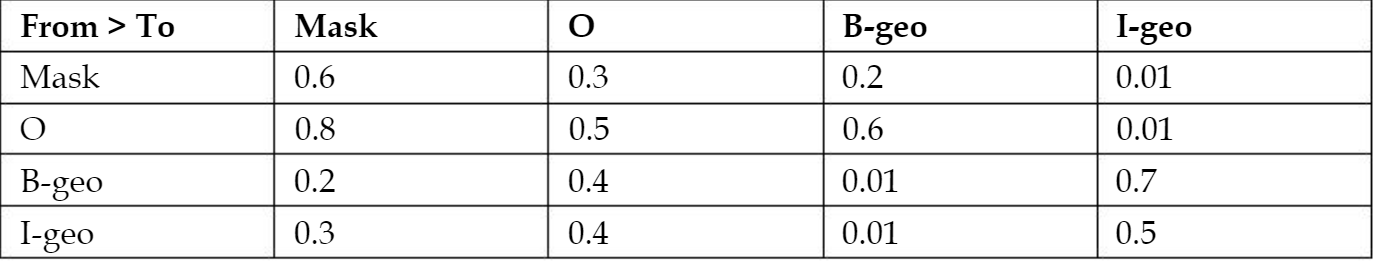


Pour expliquer le fonctionnement de l'algorithme, la gure ci-dessous sera utilisée.

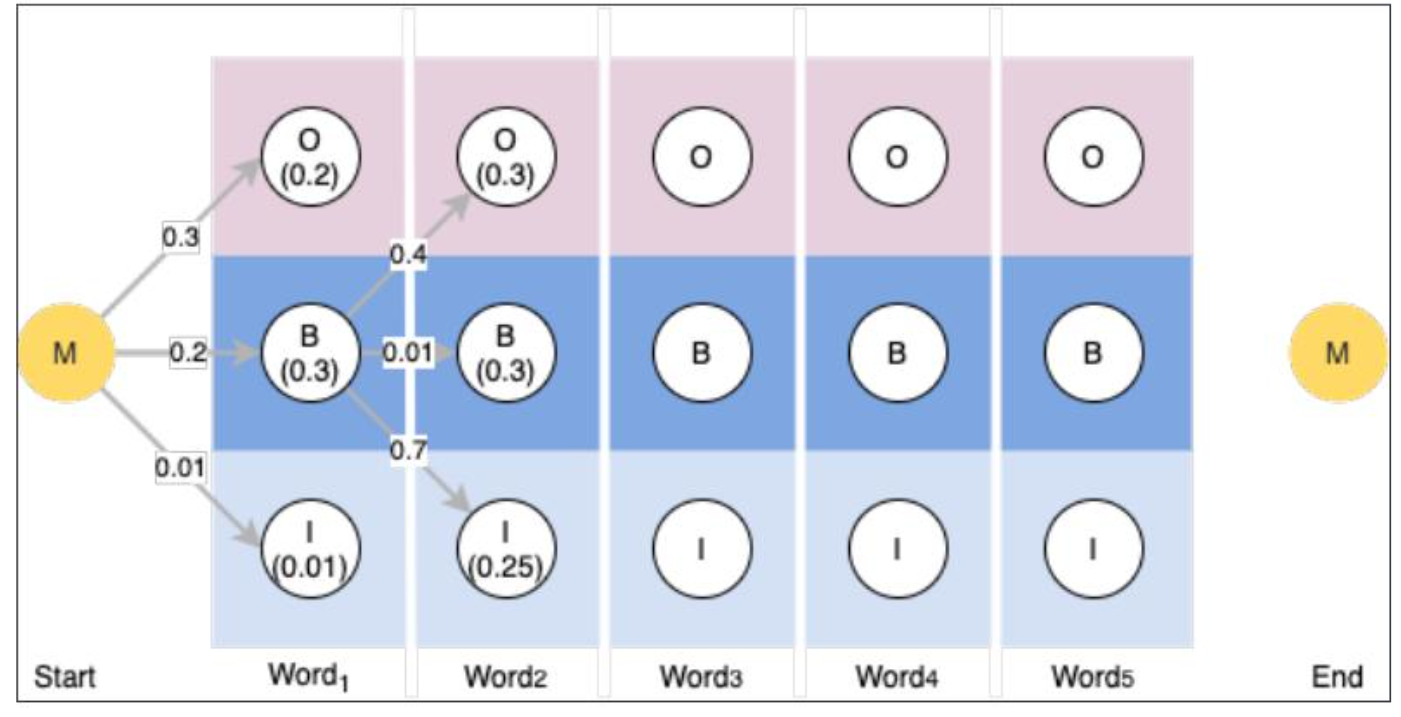

La phrase commence à gauche. Les flèches partant du début du mot jusqu'au premier jeton représentent la probabilité de transition entre les deux jetons. Les nombres sur les flèches doivent correspondre aux valeurs de la matrice de transition ci-dessus. A l'intérieur des cercles désignant les étiquettes, les scores générés par le réseau de neurones, le modèle BiLSTM, dans notre cas, sont affichés pour le premier mot. Ces scores doivent être additionnés pour donner le score final des mots. Notez que nous avons changé la terminologie des probabilités aux scores car la normalisation n'est pas effectuée pour cet exemple particulier

## he probability of the rst word label

Score of O: 0.3 (transition score) + 0.2 (activation score) = 0.5

Score of B-geo: 0.2 (transition score) + 0.3 (activation score) = 0.5

Score of I-geo: 0.01 (transition score) + 0.01 (activation score) = 0.02


À ce stade, il est également probable qu'une balise O ou B-geo soit la balise de départ. Considérons la balise suivante et calculons les scores en utilisant la même approche pour les séquences suivantes

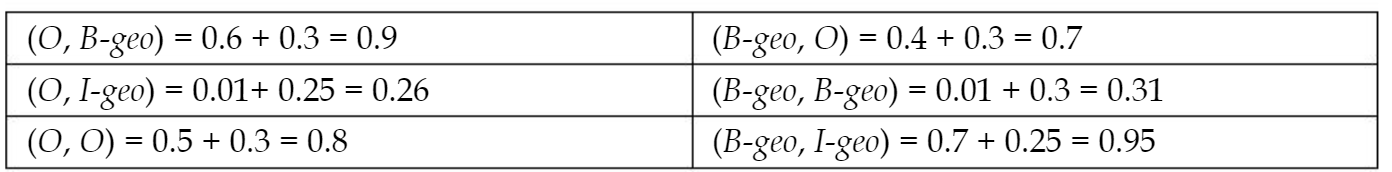


Ce processus s'appelle la passe avant. Il convient également de noter, même s'il s'agit d'un exemple artificiel, que les activations à une entrée donnée peuvent ne pas être le meilleur prédicteur de la bonne étiquette pour ce mot une fois que les étiquettes précédentes ont été prises en compte. Si la phrase ne comprenait que deux mots, les scores des différentes séquences pourraient être calculés en additionnant à chaque étape

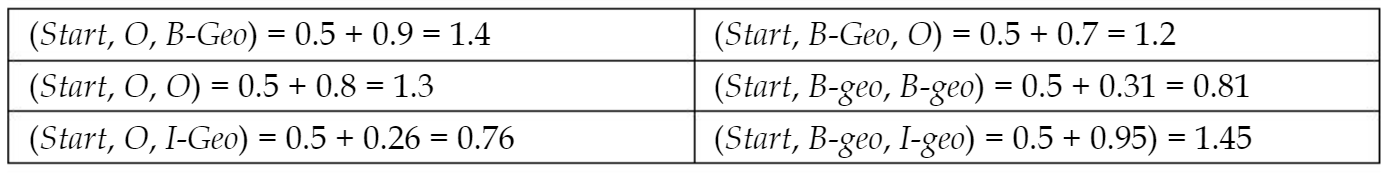

Si seuls les scores d'activation étaient considérés, les séquences les plus probables seraient soit (Start, B-geo, O) soit (Start, B-geo, B-geo). Cependant, l'utilisation des scores de transition avec les activations signifie que la séquence avec la probabilité la plus élevée est (Start, B-geo, I-geo) dans cet exemple. Alors que la passe en avant donne le score le plus élevé de toute la séquence étant donné le dernier jeton, le processus de passe en arrière reconstruirait la séquence qui a abouti à ce score le plus élevé. Il s'agit essentiellement de l'algorithme de Viterbi, qui utilise une programmation dynamique pour effectuer ces étapes de manière efcace. 

La mise en œuvre de cet algorithme est facilitée par le fait que le calcul de base est fourni en tant que méthode dans le package tfa. Cette étape de décodage sera implémentée dans la méthode call() de la couche 

La méthode viterbi_decode() prend les activations des couches précédentes et de la matrice de transition ainsi que la longueur de séquence maximale pour calculer le chemin avec le score le plus élevé. Ce score est également renvoyé, mais nous l'ignorons pour nos besoins d'inférence. Ce processus doit être effectué pour chaque séquence du lot. Notez que cette méthode renvoie des séquences sur des longueurs différentes. Cela rend plus difficile la conversion en tenseurs, donc une fonction utilitaire est utilisée pour remplir les séquences renvoyées

In [ ]:
Y_test_int = tf.cast(Y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
out = blc_model.predict(test_dataset.take(1))

In [ ]:
# check the outputs
print(out[1], tf.argmax(Y_test[1], -1))
print(out[2], tf.argmax(Y_test[2], -1))

[2 2 2 2 2 2 2 2 2 2 2 2 7 6 2 7 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 2 2 2 2 2 2 2 2 2 2 7 6 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
[2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)


In [ ]:
text_tok.sequences_to_texts([X_test[2]])

['The development Monday angered opposition protesters who said the new parliament was chosen in rigged elections . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [ ]:
print("Ground Truth: ", ner_tok.sequences_to_texts([tf.argmax(Y_test[2], -1).numpy()]))
print("Prediction: ", ner_tok.sequences_to_texts([out[2]]))

Ground Truth:  ['O O B-tim O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Prediction:  ['O O B-tim O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [ ]:
print(ner_tok.sequences_to_texts([tf.argmax(Y_test[1], -1).numpy()]))
print(ner_tok.sequences_to_texts([out[1]]))

['O O O O O O O O O O O O B-per I-per O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
['O O O O O O O O O O O O B-per I-per O B-per O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [ ]:
def np_precision(pred, true):
    # expect numpy arrays
    assert pred.shape == true.shape
    assert len(pred.shape) == 2
    mask_pred = np.ma.masked_equal(pred, 0)
    mask_true = np.ma.masked_equal(true, 0)
    acc = np.equal(mask_pred, mask_true)
    return np.mean(acc.compressed().astype(int))

In [ ]:
np_precision(out, tf.argmax(Y_test[:BATCH_SIZE], -1).numpy())

0.9639024390243902

C'est un modèle assez précis, juste après 5 époques d'entraînement et avec une architecture très simple, tout en utilisant des intégrations qui sont entraînées à partir de zéro. Une métrique de rappel peut également être mise en œuvre de la même manière. Un modèle BiLSTM uniquement, présenté plus haut, a nécessité 15 périodes d'entraînement pour obtenir une précision similaire ! Ceci termine la mise en œuvre d'un modèle NER utilisant des BiLSTM et des CRF. Si cela vous intéresse et que vous souhaitez continuer à travailler dessus, recherchez l'ensemble de données CoNLL 2003 pour NER. Même aujourd'hui, des articles sont publiés qui visent à améliorer la précision des modèles basés sur cet ensemble de données